In [52]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
print(df.columns)  # Lista todas as colunas disponíveis
df

Index(['Quarter', 'Consumption', 'Income', 'Production', 'Savings',
       'Unemployment'],
      dtype='object')


,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [53]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

Aplicando o modelo

In [54]:

# Configurar a coluna 'Quarter' como índice
df.set_index('Quarter', inplace=True)

# Escolher a coluna a ser prevista
y = df["Consumption"]

# Dividir os dados em treino e teste
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Consumption']])

# Criar sequência para LSTM
def create_sequences(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_sequences(scaled_data, look_back)

# Dividir dados em treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para o formato [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

# Fazer previsões
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Epoch 1/20
156/156 [==============================] - 2s 3ms/step - loss: 0.0429
Epoch 2/20
156/156 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 3/20
156/156 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 4/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 5/20
156/156 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 6/20
156/156 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 7/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 8/20
156/156 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 9/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 10/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 11/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 12/20
156/156 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 13/20
156/156 [====

Plotando os resultados:

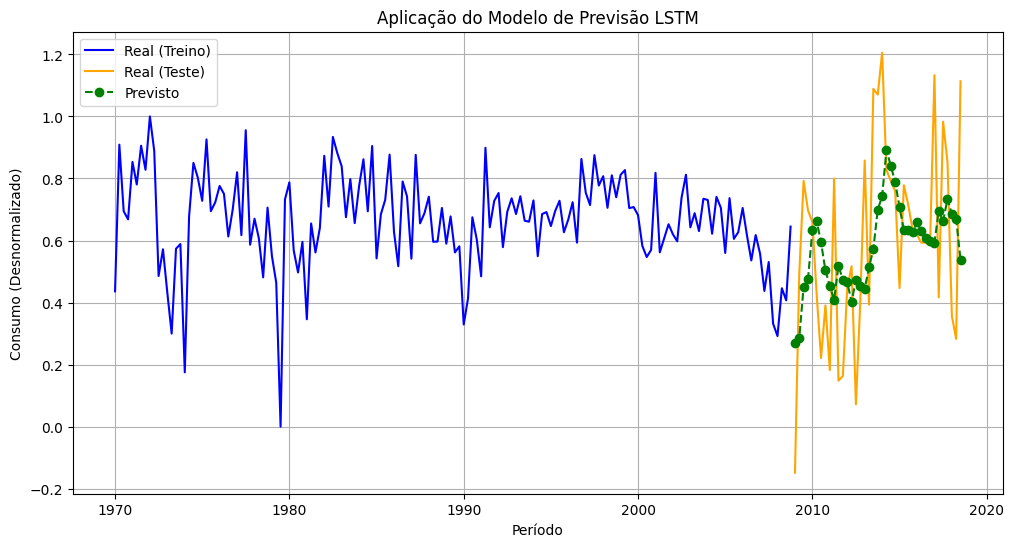

In [ ]:
# Garantir que os índices para treino e teste sejam do mesmo tipo
train_index = df.index[:len(y_train)]  # Índices correspondentes aos dados de treino
test_index = df.index[len(y_train):len(y_train) + len(y_test)]  # Índices correspondentes aos dados de teste

# Concatenar os índices
combined_index = pd.Index(list(train_index) + list(test_index))

# Criar o DataFrame para os resultados
results = pd.DataFrame({
    'Real (Treino)': np.concatenate([y_train.flatten(), [np.nan] * len(y_test)]),  # Dados reais de treino
    'Real (Teste)': np.concatenate([[np.nan] * len(y_train), y_test.flatten()]),  # Dados reais de teste
    'Previsto': np.concatenate([[np.nan] * len(y_train), y_pred.flatten()])  # Previsões apenas no teste
}, index=combined_index)  # Usar o índice combinado

# Converter índice para datetime (se necessário)
if isinstance(results.index, pd.PeriodIndex):
    results.index = results.index.to_timestamp()

# Visualizar os resultados
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Real (Treino)'], label='Real (Treino)', color='blue', linestyle='-')
plt.plot(results.index, results['Real (Teste)'], label='Real (Teste)', color='orange', linestyle='-')
plt.plot(results.index, results['Previsto'], label='Previsto', color='green', linestyle='--', marker='*')
plt.title('Aplicação do Modelo de Previsão LSTM')
plt.xlabel('Período')
plt.ylabel('Consumo (Desnormalizado)')
plt.legend()
plt.grid(True)
plt.show()



